<a href="https://colab.research.google.com/github/willystumblr/AI-ML_Team_5/blob/kms/Week3/NLP_Week_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

# Single Layer LSTM

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.6.0


# `__future__` module
|기능    |효과|
|-------|-----|
|nested_scopes|정적으로 중첩된 스코프|
|generators|단순 제너레이터|
|division|나누기 연산자 변경|
|absolute_import|임포트: 복수 줄 및 절대/상대|
|with_statement|《with》 문|
|print_function|print를 함수로 만들기|
|unicode_literals|파이썬 3000의 바이트열 리터럴|
|generator_stop|제너레이터 내부의 StopIteration 처리|
|annotations|어노테이션의 지연된 평가|

## 사용이유
> `__future__`는 코드를 기계어로 바꿔주는 컴파일러에게 “미래의, 장차 배포될 파이썬의 표준에 적합하게(에러를 발생시키지 않도록) 특정 모듈(함수)을 실행시키시오.” 라는 명령을 내리는 것과 같습니다.
현재 우리는 파이썬 3.x 버전을 사용하고 있지만, 이전에는 파이썬 2.x 버전이 있었습니다. 위의 설명에 따르면, `__future__` 덕분에 우리는 과거 파이썬 버전 (예시. 파이썬 2.5) 에서 작성된 코드라도 현재의 파이썬 버전 (예시. 파이썬 3.6) 에서 성공적으로 실행시킬 수 있게 됩니다.
즉, 함수 실행시 최신의 파이썬 버전 표준에 맞게 “알아서 잘” 작동하도록 지시를 해 줘야 하기 때문에, `__future__` 가 전체 프로그램 코드의 상단에 위치해야 하는 것입니다.

In [2]:
# Get the data
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete9A1II7/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete9A1II7/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete9A1II7/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


* `with_info`: `bool`, if True, `tfds.load` will return the tuple (`tf.data.Dataset`, `tfds.core.DatasetInfo`), the latter containing the info associated with the builder.
* `as_supervised`: `bool`, if True, the returned `tf.data.Dataset` will have a 2-tuple structure (input, label) according to builder.info.supervised_keys. If False, the default, the returned `tf.data.Dataset` will have a dictionary with all the features.


In [3]:
tokenizer = info.features['text'].encoder

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


# Creating model
* Layer(type) : 레이어의 이름과 타입을 나타냅니다. 알아서 레이어의 이름을 지정해줍니다. 따로 지정해주고 싶을때는 Dense에 파라미터로 `name='지정하고싶은 이름'`을 주면 됩니다. 
* Output Shape: (None, 64)이라는 뜻은 None개의 행과 64개의 아웃풋 값이 주어졌다는 것을 뜻합니다. 행이 None으로 지정되는 이유는 데이터의 갯수는 계속해서 추가될 수 있기 때문에 딥러닝 모델에서는 주로 행을 무시하고 열의 shape을 맞추어주는 작업을 많이 수행합니다. 
* Param: 파라미터의 수, 즉 각 입력노드와 출력노드에 대해 연결된 간선의 수를 뜻합니다. 

출처: [Dev Log : 삶은 확률의 구름](https://ebbnflow.tistory.com/124)

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

`compile`:  you can config the model with losses and metrics with `model.compile()`

[list of args]
* `loss`: loss function. 
* `matrics`: List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a `tf.keras.metrics.Metric` instance. See tf.keras.metrics. Typically you will use `metrics=['accuracy']`.
* `optimizer`: String (name of optimizer) or optimizer instance.


In [8]:
NUM_EPOCHS = 10
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 174s 422ms/step - loss: 0.5415 - accuracy: 0.7193 - val_loss: 0.5061 - val_accuracy: 0.7656
Epoch 2/10
391/391 [==============================] - 165s 420ms/step - loss: 0.3654 - accuracy: 0.8496 - val_loss: 0.4165 - val_accuracy: 0.8205
Epoch 3/10
391/391 [==============================] - 165s 421ms/step - loss: 0.2887 - accuracy: 0.8877 - val_loss: 0.4225 - val_accuracy: 0.8324
Epoch 4/10
391/391 [==============================] - 166s 423ms/step - loss: 0.2365 - accuracy: 0.9100 - val_loss: 0.4927 - val_accuracy: 0.8249
Epoch 5/10
391/391 [==============================] - 166s 423ms/step - loss: 0.1922 - accuracy: 0.9288 - val_loss: 0.6029 - val_accuracy: 0.7798
Epoch 6/10
391/391 [==============================] - 166s 422ms/step - loss: 0.1636 - accuracy: 0.9410 - val_loss: 0.5399 - val_accuracy: 0.7795
Epoch 7/10
391/391 [==============================] - 164s 418ms/step - loss: 0.1265 - accuracy: 0.9552 - val_loss: 0.6128 -

`fit`: Trains the model for a fixed number of epochs (iterations on a dataset).
[list of args]
* `x`: Input data. It could be:
  * A Numpy array (or array-like), or a list of arrays (in case the model has multiple inputs).
  * A TensorFlow tensor, or a list of tensors (in case the model has multiple inputs).
  * A dict mapping input names to the corresponding array/tensors, if the model has named inputs.
  * A `tf.data` dataset. Should return a tuple of either (inputs, targets) or (inputs, targets, sample_weights).
  * A generator or `keras.utils.Sequence` returning (inputs, targets) or (inputs, targets, sample_weights).
  * A `tf.keras.utils.experimental.DatasetCreator`, which wraps a callable that takes a single argument of type `tf.distribute.InputContext`, and returns a `tf.data.Dataset`. `DatasetCreator` should be used when users prefer to specify the per-replica batching and sharding logic for the Dataset.
* `y`: Target data. Like the input data `x`, it could be either Numpy array(s) or TensorFlow tensor(s). It should be consistent with `x` (you cannot have Numpy inputs and tensor targets, or inversely). If `x` is a dataset, generator, or `keras.utils.Sequence` instance, __`y` should not be specified__ (since targets will be obtained from x).

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

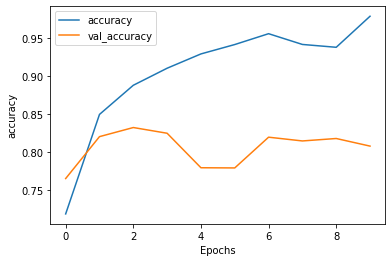

In [10]:
plot_graphs(history, 'accuracy')

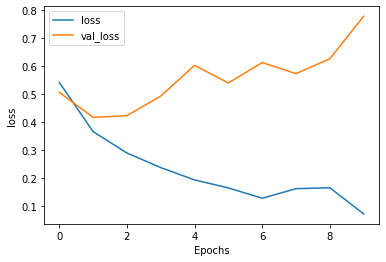

In [11]:
plot_graphs(history, 'loss')